In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

####

Lecture du csv


####

In [2]:
df = pd.read_csv("./data/chansons.csv")
df.shape

(7574, 39)

###

39 colonnes... possible/probablement on aura de la colinéarité

Analysons un peu plus

###

In [3]:
df.isnull().sum()

annee                       0
titre                       0
artiste                     0
chansonID                   0
artisteID                   0
signature_temp              0
signature_temp_confiance    0
intensite                   0
tempo                       0
tempo_confiance             0
gamme                       0
gamme_confiance             0
energie                     0
hauteur                     0
timbre_0_min                0
timbre_0_max                0
timbre_1_min                0
timbre_1_max                0
timbre_2_min                0
timbre_2_max                0
timbre_3_min                0
timbre_3_max                0
timbre_4_min                0
timbre_4_max                0
timbre_5_min                0
timbre_5_max                0
timbre_6_min                0
timbre_6_max                0
timbre_7_min                0
timbre_7_max                0
timbre_8_min                0
timbre_8_max                0
timbre_9_min                0
timbre_9_m

###

Pas de nulls à régler

###

###

Obtention des dfX (var indépend) et dfY (target, var dépend)


###

In [234]:
## retourne les dataframes X et Y. Par défaut, supprimer les colonnes ID
def getDfXDfY(pDf, pColY, pColsXDrop=['chansonID', 'artisteID']):
    dfY = pd.DataFrame(pDf[pColY], columns = [pColY])
    #print(type(pColsXDrop))
    #print(type(pColY))
    lstColsExcl=[]
    lstColsExcl.extend(pColsXDrop)
    lstColsExcl.append(pColY)
    print(lstColsExcl)
    dfX = pDf.drop(lstColsExcl, axis=1)
    return dfX, dfY

In [235]:
dfX, dfY = getDfXDfY(df, 'Top10')

['chansonID', 'artisteID', 'Top10']


In [236]:
dfX.dtypes

annee                         int64
titre                        object
artiste                      object
signature_temp                int64
signature_temp_confiance    float64
intensite                   float64
tempo                       float64
tempo_confiance             float64
gamme                         int64
gamme_confiance             float64
energie                     float64
hauteur                     float64
timbre_0_min                float64
timbre_0_max                float64
timbre_1_min                float64
timbre_1_max                float64
timbre_2_min                float64
timbre_2_max                float64
timbre_3_min                float64
timbre_3_max                float64
timbre_4_min                float64
timbre_4_max                float64
timbre_5_min                float64
timbre_5_max                float64
timbre_6_min                float64
timbre_6_max                float64
timbre_7_min                float64
timbre_7_max                

In [240]:
print(len(dfX['artiste'].unique()))
print(len(dfX['titre'].unique()))


1032
7141


####

Qu'est-ce qu'on fait avec les variables texte? On crée environ 8k colonnes avec get_dummies?
On les drop?

Pour l'instant, on va les ignorer (drop)

####

In [241]:
## obtention d'un df numérique

dfXNum = dfX.select_dtypes(exclude=['object'])

In [284]:
dfXNum.isnull().values.sum()

0

####

On prevoit les top 10.
Voyons qui sont les top 10 


#####

In [242]:
dfTop10 = df[(df['Top10']==1)]

####

On voit que 1119/7574 sont top 10 artists.
Examinons un petit plus

####

In [243]:
nbTop10Artistes = len(dfTop10['artiste'].unique())
nbArtistes = len(df['artiste'].unique())

nbRowsTop10 = len(dfTop10)
nbRowsTotal = len(df)

print ('nb top 10 artistes: ', nbTop10Artistes)
print ('nb artistes: ', nbArtistes)
print ('% artistes dans le top 10: ' , round((nbTop10Artistes/nbArtistes), 2))
print ('% de rows du dataframe qui sont dans le top 10: ', round((nbRowsTop10/nbRowsTotal), 2))
       


nb top 10 artistes:  576
nb artistes:  1032
% artistes dans le top 10:  0.56
% de rows du dataframe qui sont dans le top 10:  0.15


###

Un peu plus que la moitié d'artistes sont dans le Top 10 
Environ 15% des enregistrements correspondent au Top 10



###

In [244]:
## cela tue le kernel
#sns.pairplot(df)

###

Baseline - dummy classifier

###

In [245]:
### Dummy Classifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [246]:
## plot la matrice confusion
def print_confusion_matrix(pDfYTest, pDfYPredictTest):
    matrix = confusion_matrix(y_true=pDfYTest, y_pred=pDfYPredictTest)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

In [247]:
## roc courbe
def print_roc_auc(pDfYTest, pDfYPredictTest):
    fpr, tpr, thresholds = metrics.roc_curve(pDfYTest, pDfYPredictTest)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,)
    roc_display.plot()

In [248]:

## precision recall curve
def print_precision_recall(pYTest, pYTestPred):
    precision, recall, thresholds = precision_recall_curve(pYTest, pYTestPred)
    fig = plt.figure(7, figsize=(6,6))
    plt.plot(recall, precision, color='b')
    plt.xlabel('Recall')
    plt.xlabel('Precision')
    plt.title('Precision-Recall curve')

In [249]:
## imprime les metrics
def print_metrics(pDfYVal, pDfYValPredLabel):
    print("[score]: ", accuracy_score(pDfYVal, pDfYValPredLabel))
    fpr, tpr, thresholds = metrics.roc_curve(pDfYVal, pDfYValPredLabel)
    
    ## sensitivity: the % of all 1s that are correctly classified as 1
    ## recall = sensitivty 
    print("[sensitiviy (recall)]: ", metrics.recall_score(pDfYVal, pDfYValPredLabel))
    
    #y_true = pDfYVal
    #y_pred = pDfYValPredLabel
    
    ## sensitivity: the % of all 1s that are correctly classified as 1
    #print ("tpr: ", tpr)
    #print ("fpr: ", fpr)
    #sensitivity = tpr/(tpr+fpr)
    #print("[sensitivity]: ", sensitivity)
    #print("---report---")
    #print(classification_report(y_true, y_pred))
    

In [250]:
### retourne les dataframes X et Y: train, validation et test (donc, 6 dataframes de retour). 
def get_train_val_test(pDfX, pDfY,  pTestSize=0.2):
    ### test
    X_train_0, X_test, y_train_0, y_test = train_test_split(pDfX
                                                            , pDfY
                                                            , test_size=pTestSize
                                                            , shuffle=True
                                                            , random_state=0
                                                            , stratify=pDfY
                                                           )
    ## train, val
    X_train, X_val, y_train, y_val = train_test_split(X_train_0
                                                      , y_train_0
                                                      , train_size=0.5
                                                      , shuffle=True
                                                      , random_state=0
                                                      , stratify=y_train_0
                                                     )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [252]:
### analyse d'un modèle pModel
def analyze_model(pDfX, pDfY, pModel, pTestSize=0.2, pThreshold=0.5 ):
    
    
    ### test
    #X_train_0, X_test, y_train_0, y_test = train_test_split(pDfX
    #                                                        , pDfY
    #                                                        , test_size=pTestSize
    #                                                        , shuffle=True
    #                                                        , random_state=0
    #                                                        , stratify=pDfY
    #                                                       )
    ## train, val
    #X_train, X_val, y_train, y_val = train_test_split(X_train_0
    #                                                  , y_train_0
    #                                                  , train_size=0.5
    #                                                  , shuffle=True
    #                                                  , random_state=0
    #                                                  , stratify=y_train_0
    #                                                 )
    
    ## Obtention des df train, val, test
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test(pDfX, pDfY)
    
    pModel.fit(X_train, y_train)
    y_val_pred_proba = pModel.predict_proba(X_val)[:, 1]
    
    ## 0 ou 1
    y_val_pred_label = y_val_pred_proba > pThreshold ## rigidification
    
    print("model.score: ", pModel.score(X_val, y_val))
    
    print_metrics(y_val, y_val_pred_proba)
    
    print_confusion_matrix(y_val, y_val_pred_proba)
    
    print_roc_auc(y_val, y_val_pred_proba)
    
    ## dummy n'a pas decision function
    #if(hasattr(pModel, 'decision_function')):
    print_precision_recall(y_val, y_val_pred_proba)

In [253]:
### dummy
def analyze_dummy(pDfX, pDfY, pTestSize=0.2, pThreshold=0.5):
    model = DummyClassifier(strategy="most_frequent")
    analyze_model(pDfX, pDfY, model, pTestSize=0.2, pThreshold=0.5)
    
   

model.score:  0.8521452145214522
[score]:  0.8521452145214522
[sensitiviy (recall)]:  0.0


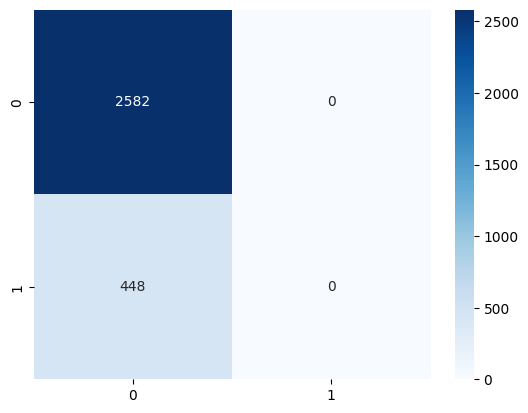

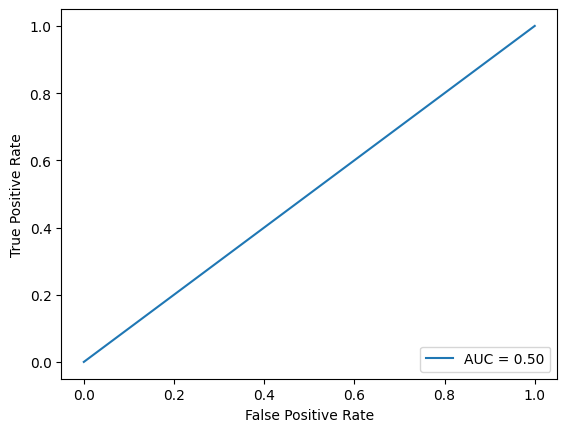

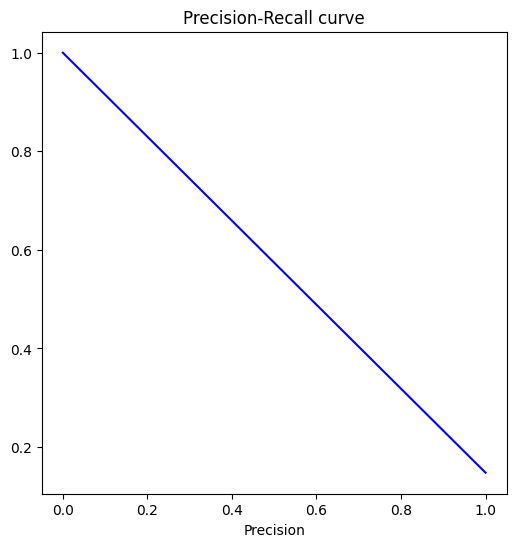

In [254]:
analyze_dummy(dfXNum, dfY)

####

Le résultat est cohérent. Le dummy sort toujours la valeur la plus fréquente (0 dans environ 100-15=85% de cas)

Pourtant, ce 85% de précision ne veut pas dire grandes choses. On est dans un 'Rare Class Problem' où le 1
(top 10) est beaucoup moins représenté que le 0. (Pour ma propre référence: livre Practical Statistics for Data Scientist, pg 223).

Dans le cas du top 10, je prends la sensibilité, la capacité du modèle de predire un positif, comme une métrique plus importante que la précision. Et dans ce cas, notre sensibilité =0 (aucune prediction positive), ce qui est normal pour le dummy classifier vu que le 0 est la classe la plus fréquente.

Concernant la courbe roc, le dummy coïncide avec la diagonale, c'est qui est vraiment le baseline.

Pour les autres modèles, on attend une courbe au dessus de la ligne bleue

####

In [293]:
## https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.compose import ColumnTransformer

In [295]:


## obtentions train, val, text
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test(dfXNum, dfY)

numeric_transformer = Pipeline(steps=[    
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, dfXNum)])

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [277]:
## implémentation comme celle-ci:
## https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = [
    "Nearest Neighbors"
    , "Decision Tree"
    , "Random Forest"
    , "AdaBoost"
]

classifiers = [
    KNeighborsClassifier(3)
    , DecisionTreeClassifier(max_depth=5)
    , RandomForestClassifier(max_depth=5, n_estimators=100)
    , AdaBoostClassifier()
]

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

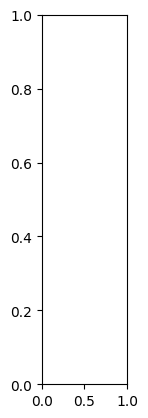

In [285]:
## obtentions train, val, text
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test(dfXNum, dfY)
#print(type(y_test))
i=1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers)+1, i)
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train.values.ravel())
    score = clf.score(X_val, y_val)
    #DecisionBoundaryDisplay.from_estimator(
    #    clf, dfXNum, alpha=0.8, eps=0.5
    #)
    i+=1